<a href="https://colab.research.google.com/github/SayatAbdikul/animal_classification_model/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder


In [22]:
image_size = 240
transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
folder_path = '/content/drive/My Drive/animals-10'
dataset = ImageFolder(root=folder_path, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [18]:
class_names = dataset.classes

In [19]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

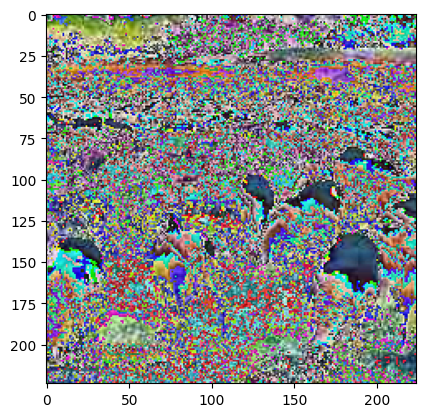

In [6]:
import matplotlib.pyplot as plt
image = next(iter(train_dataloader))[0][0]
to_pil = transforms.ToPILImage()
plt.imshow(to_pil(image))
plt.show()

# Helper functions

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [8]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if len(X) == 0:
            print(f"empty batch on {batch}")
            continue
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 10 == 0:
          print(f"looked at batch: {batch}/ {len(dataloader)}")
    print(f"Train loss: {train_loss/len(train_dataloader):.5f} | Train accuracy: {train_acc/len(train_dataloader):.2f}%")

In [9]:
def evaluation_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    device: torch.device) -> float:
    model.eval()
    with torch.inference_mode():
        eval_loss, eval_acc = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            if len(X) == 0:
                print(f"empty batch on {batch}")
                continue
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            eval_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        print(f"Model loss: {eval_loss/len(val_dataloader):.5f} | Model accuracy: {eval_acc/len(val_dataloader):.2f}%")

# Pre-trained B0 model

In [25]:
import torchvision
from torchvision import models
trained_model = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
from torch import nn
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=trained_model.parameters(), lr=0.1)
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=trained_model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    evaluation_step(model=trained_model, dataloader=val_dataloader, loss_fn=loss_fn, device=device)

Epoch: 0
---------
looked at batch: 0/ 252


KeyboardInterrupt: 

In [27]:
evaluation_step(model=trained_model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

Model loss: 6.78398 | Model accuracy: 1.10%


# EfficientNet-B0. Baseline with convolution

## Creating the MBConvBlock and adaptive EfficientNet model

In [13]:
class MBConvBlock_B0(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, expansion: int):
        super(MBConvBlock_B0, self).__init__()

        self.use_residual = (in_channels == out_channels) and (stride == 1)

        hidden_dim = in_channels * expansion
        layers = []

        # Expansion phase
        if expansion != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))

        # Depthwise convolution phase
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU(inplace=True))

        # Pointwise-linear phase
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [15]:
from torch import nn
class EfficientNet(nn.Module):
    def __init__(self, num_classes=1000, MBConvBlock=MBConvBlock_B0):
        super(EfficientNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.blocks = nn.Sequential(
            MBConvBlock(in_channels=64, out_channels=16, expansion=1, stride=1),
            MBConvBlock(in_channels=16, out_channels=24, expansion=6, stride=2),
            MBConvBlock(in_channels=24, out_channels=40, expansion=6, stride=2),
            MBConvBlock(in_channels=40, out_channels=80, expansion=6, stride=2),
            MBConvBlock(in_channels=80, out_channels=112, expansion=6, stride=1),
            MBConvBlock(in_channels=112, out_channels=192, expansion=6, stride=2),
            MBConvBlock(in_channels=192, out_channels=320, expansion=6, stride=1)
        )
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Training/evaluating the model

In [20]:
model_1 = EfficientNet(num_classes=len(class_names), MBConvBlock=MBConvBlock_B0)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_1.to(device)

EfficientNet(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): Sequential(
    (0): MBConvBlock_B0(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [21]:
torch.manual_seed(7)
epochs = 8
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model_1, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    evaluation_step(model=model_1, dataloader=val_dataloader, loss_fn=loss_fn, device=device)

Epoch: 0
---------
looked at batch: 0/ 72


KeyboardInterrupt: 

In [ ]:
evaluation_step(model=model_1, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

# EfficientNet-B1

## Creating the MBConvBlock for this model

In [ ]:
class MBConvBlock_B1(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, stride: int, expansion: int):
    super(MBConvBlock_B1, self).__init__()